Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Info] Number of positive: 9240, number of negative: 16052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 25292, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 9240, number of negative: 16052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 25292, number of used features: 99
[LightGBM] [Info] [binary

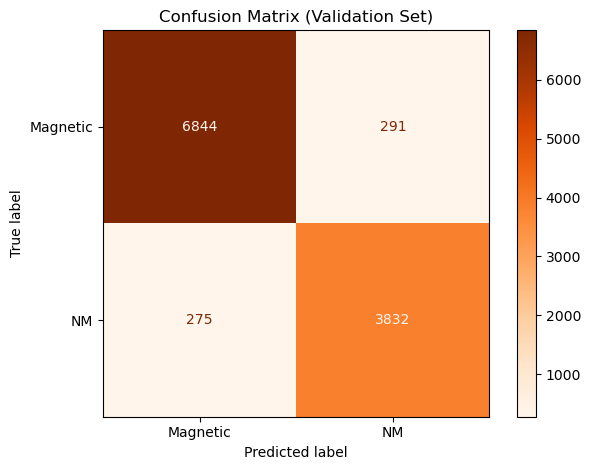

In [1]:
# Full corrected code using LightGBM for 4-class classification with hyperparameter tuning and overfitting check

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier

# === 1. Load Data ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# ===  Merge FM, FiM, and AFM into one class: Magnetic ===
df["ordering"] = df["ordering"].replace({"FM": "Magnetic", "FiM": "Magnetic", "AFM": "Magnetic"})

# === 2. Parse elements ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing data ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements and crystal system ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 6. Combine features ===
X_raw = pd.concat([df[numerical_features].reset_index(drop=True),
                   element_df.reset_index(drop=True),
                   crystal_df.reset_index(drop=True)], axis=1)
X = X_raw.values

# === 7. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 8. Train/Val/Test split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 9. Hyperparameter tuning ===
param_grid = {
    'num_leaves': [63],
    'max_depth': [-1],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'class_weight': ['balanced']
}

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=lgbm_model,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=skf,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# === 10. Classification Reports ===
print("✅ Best Parameters:", grid_search.best_params_)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))


# === 11. Confusion Matrices ===
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()




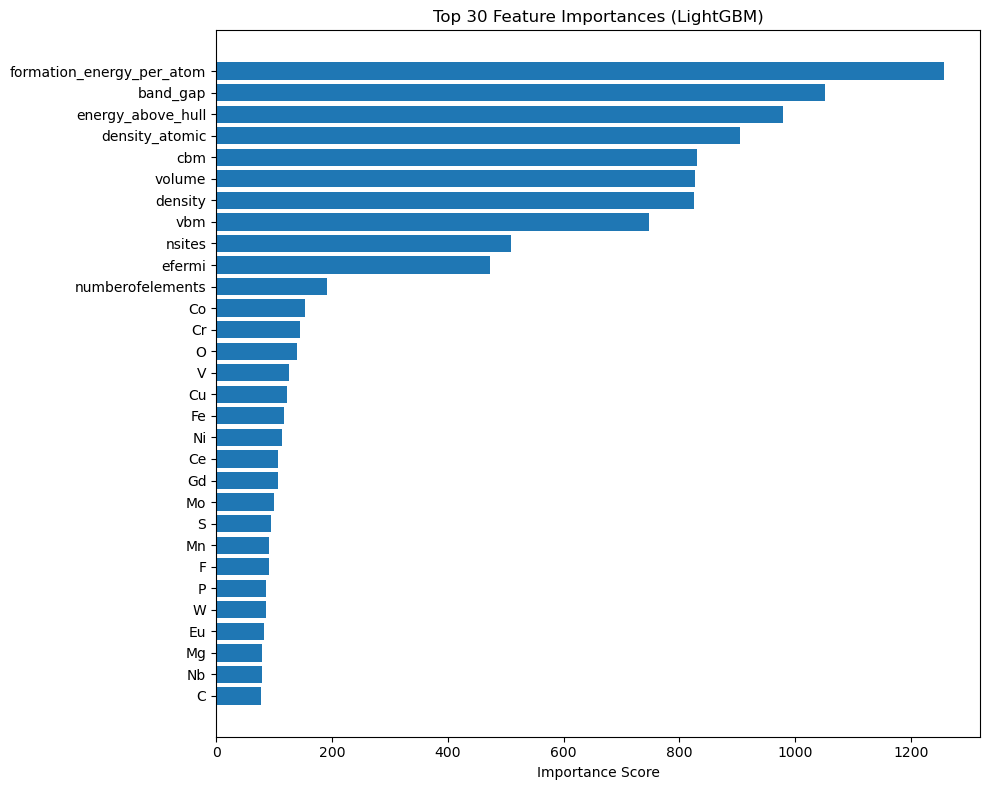

In [2]:
importances = best_model.feature_importances_
feature_names = X_raw.columns  # Retain column names for clarity

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'].head(30)[::-1], feat_imp_df['Importance'].head(30)[::-1])
plt.xlabel("Importance Score")
plt.title("Top 30 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


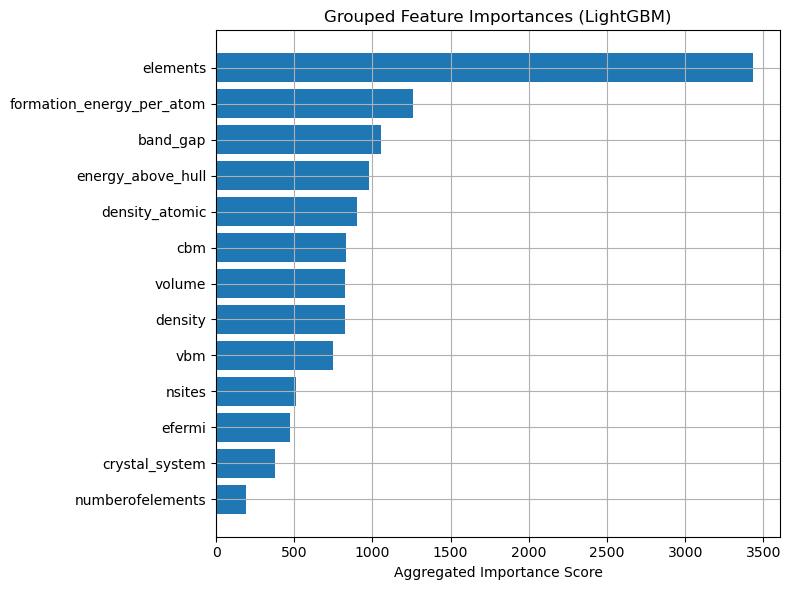

                    Group  Importance
                 elements        3434
formation_energy_per_atom        1256
                 band_gap        1052
        energy_above_hull         979
           density_atomic         904
                      cbm         830
                   volume         826
                  density         825
                      vbm         747
                   nsites         509
                   efermi         473
           crystal_system         374
         numberofelements         191


In [3]:
# Step 1: Regenerate X_raw after combining features (same order as model input)
X_raw = pd.concat([df[numerical_features].reset_index(drop=True),
                   element_df.reset_index(drop=True),
                   crystal_df.reset_index(drop=True)], axis=1)

importances = best_model.feature_importances_
assert len(importances) == X_raw.shape[1], "Mismatch between features and importances!"

# Step 2: Identify feature groups
feature_groups = []
for col in X_raw.columns:
    if col in numerical_features:
        feature_groups.append(col)
    elif col in element_df.columns:
        feature_groups.append("elements")
    elif col in crystal_df.columns:
        feature_groups.append("crystal_system")
    else:
        feature_groups.append("other")

# Step 3: Create and aggregate importance DataFrame
feat_imp_df = pd.DataFrame({
    'Group': feature_groups,
    'Importance': importances
})
agg_df = feat_imp_df.groupby('Group', as_index=False).sum().sort_values(by='Importance', ascending=False)

# Step 4: Plot grouped importances
plt.figure(figsize=(8, 6))
plt.barh(agg_df['Group'][::-1], agg_df['Importance'][::-1])
plt.xlabel("Aggregated Importance Score")
plt.title("Grouped Feature Importances (LightGBM)")
plt.tight_layout()
plt.grid(True)
plt.show()

# Optional: Print the summary
print(agg_df.to_string(index=False))
